<a href="https://colab.research.google.com/github/kyulee-jeon/Tutorial/blob/main/Week10_(1)ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [ ]:
#Connection to GoogleDrive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
from glob import glob
import numpy as np
import cv2
import pickle
from PIL import Image

In [ ]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/2022MedicalMachineLearning/data/COVID-19_Radiography_Dataset"
"""
#Define the file paths
all_covid_paths = [f for f in glob(os.path.join(data_path, 'COVID', 'images', 'COVID*.png'))]
#all_opac_paths = [f for f in glob(os.path.join(data_path, 'Lung_Opacity', 'images', 'Lung_Opacity*.png'))]
all_normal_paths = [f for f in glob(os.path.join(data_path, 'Normal', 'images', 'Normal*.png'))]
# all_data_paths = all_covid_paths + all_opac_paths + all_normal_paths
"""

In [ ]:
"""
list_x = []
list_y = []

#load the images
for filepath in all_normal_paths[:5000]: #only upto 5000 cases due to limited resources
  i = len(list_x)
  list_x.append(cv2.imread(filepath,0))
  #list_x.append(Image.open(filepath).convert('RGB')) #covert to RGB
  if(len(list_x)==i+1): #add label only when the data is loaded
    list_y.append(0) #label normal

for filepath in all_covid_paths:
  i = len(list_x)
  list_x.append(cv2.imread(filepath,0))
  #list_x.append(Image.open(filepath).convert('RGB'))
  if(len(list_x)==i+1): #add label only when the data is loaded
    list_y.append(1) #label covid

#save the list
with open(os.path.join(data_path, "list_x_wk10"), "wb") as f:
  pickle.dump(list_x, f)
with open(os.path.join(data_path, "list_y_wk10"), "wb") as f:
  pickle.dump(list_y, f)
"""

In [ ]:
#load the list
with open(os.path.join(data_path, "list_x_wk10"), "rb") as f:
  list_x = pickle.load(f)
with open(os.path.join(data_path, "list_y_wk10"), "rb") as f:
  list_y = pickle.load(f)

#list_y = list(map(lambda x: x.replace('0', 'c'), list_y))
#list_y = list(map(lambda x: x.replace('1', 't'), list_y))

In [ ]:
print("The length of list_x is {}".format(len(list_x)))
print("The length of list_y is {}".format(len(list_y)))
print("The shape of first element of list_x is {}".format(list_x[0].shape))

The length of list_x is 8616
The length of list_y is 8616
The shape of first element of list_x is (299, 299)


In [ ]:
#convert to ndarray of the data
data_x = np.array(list_x, dtype = np.float32)
data_y = np.array(list_y)

In [ ]:
#Check the class balance
import pandas as pd
pd.Series(data_y).value_counts()

0    5000
1    3616
dtype: int64

In [ ]:
data_x[1]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 42., 54., 56.],
       [ 0.,  0.,  4., ..., 51., 61., 62.],
       [ 0.,  1.,  9., ..., 59., 69., 71.]], dtype=float32)

In [ ]:
data_x = data_x/255.0
#one hot encoding
data_y_ = data_y.reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit(data_y_)
data_y = ohe.transform(data_y_)

In [ ]:
data_x[1]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.16470589, 0.21176471,
        0.21960784],
       [0.        , 0.        , 0.01568628, ..., 0.2       , 0.23921569,
        0.24313726],
       [0.        , 0.00392157, 0.03529412, ..., 0.23137255, 0.27058825,
        0.2784314 ]], dtype=float32)

Data Preprocessing

In [ ]:
# split into train test sets (stratified)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.20, random_state=10, stratify=data_y)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6892, 299, 299)
(1724, 299, 299)
(6892, 2)
(1724, 2)


In [ ]:
import torch

#convert ndarray(numpy) to tensor(torch)
x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

#combining train and test set in tensor dataset of torch
ds_train = torch.utils.data.TensorDataset(x_train, y_train)
ds_test = torch.utils.data.TensorDataset(x_test, y_test)

Defining the model

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [ ]:
output_dim = 2
input_dim = 89401#89401= 299*299

In [ ]:
from torch import nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256) #89401= 299*299
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = x.view(-1, input_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

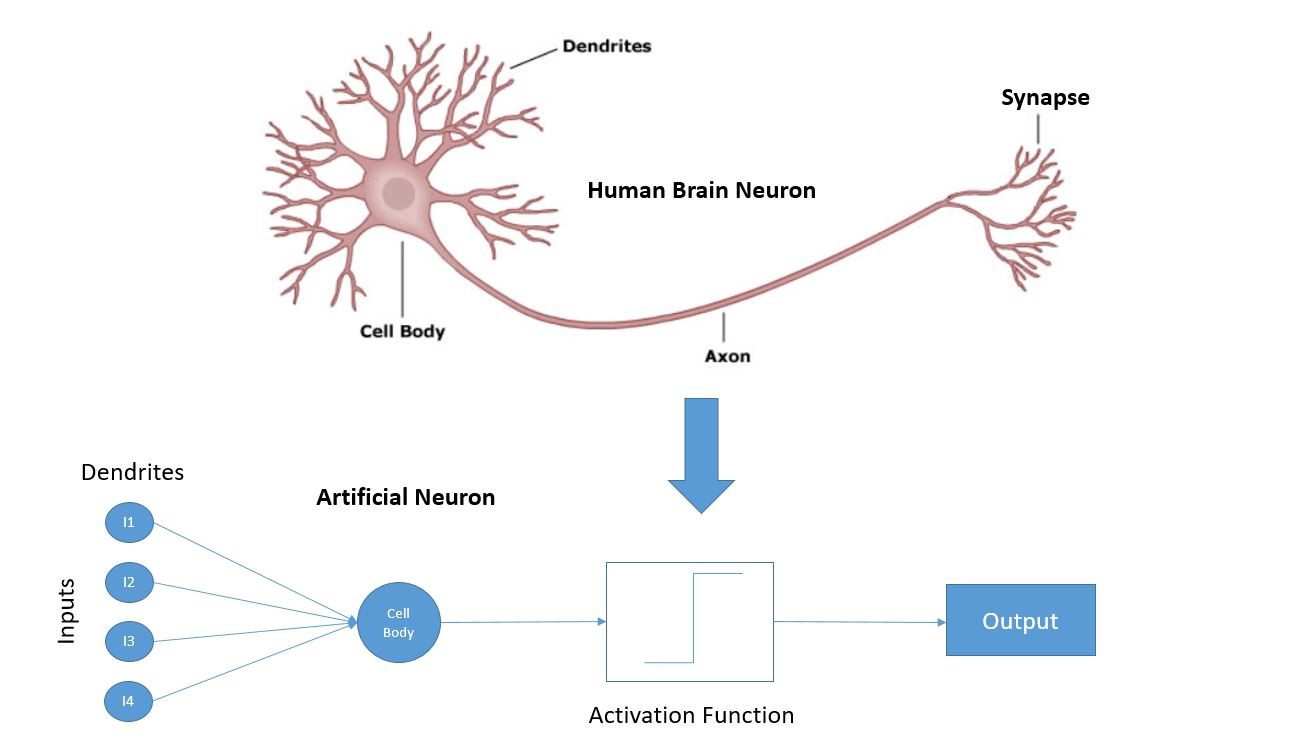
source: www.mplsvpn.info 2017 11 what-is-neuron-and-artificial-neuron-in.html

In [ ]:
model = Net().to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size = (299,299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]      22,886,912
            Linear-2                  [-1, 128]          32,896
            Linear-3                    [-1, 2]             258
Total params: 22,920,066
Trainable params: 22,920,066
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.34
Forward/backward pass size (MB): 0.00
Params size (MB): 87.43
Estimated Total Size (MB): 87.78
----------------------------------------------------------------


Configuration of Training

In [ ]:
batch_size = 128
epochs = 10
learning_rate = 0.01

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset = ds_train,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = ds_test,
    batch_size = batch_size,
    shuffle = True
)


In [ ]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
#Debugging
"""
dataiter = iter(train_loader)
data, target = next(dataiter)
data, target = data.to(device), target.to(device)
optimizer.zero_grad()
output = model(data)
loss = F.cross_entropy(output, target)
loss.backward()
optimizer.step()
"""

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum of all loss values
            test_loss += F.cross_entropy(output, target,reduction='sum').item()
            
            # the class with the maximal value is the predicted value
            pred = output.max(1, keepdim=True)[1]
            target_label = target.max(1, keepdim=True)[1]
            correct += pred.eq(target_label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
#Debugging
"""
dataiter = iter(train_loader)
data, target = next(dataiter)
data, target = data.to(device), target.to(device)
optimizer.zero_grad()
output = model(data)
loss = F.cross_entropy(output, target)
loss.backward()
optimizer.step()
"""

Fitting the model

In [ ]:
for epoch in range(1, epochs):
  train(model, train_loader, optimizer)
  test_loss, test_accuracy = evaluate(model, test_loader)

  print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'. format(epoch, test_loss, test_accuracy))

[1] Test Loss: 0.6758, Accuracy: 58.76%
[2] Test Loss: 0.6603, Accuracy: 61.95%
[3] Test Loss: 0.5384, Accuracy: 70.53%
[4] Test Loss: 0.5207, Accuracy: 71.93%
[5] Test Loss: 0.6664, Accuracy: 61.66%
[6] Test Loss: 0.5007, Accuracy: 74.77%
[7] Test Loss: 0.4941, Accuracy: 75.52%
[8] Test Loss: 0.5422, Accuracy: 72.68%
[9] Test Loss: 0.5314, Accuracy: 71.46%
